In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os,glob
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import ast
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Concatenate, Dense, GRU, Input, concatenate,Dropout,LeakyReLU
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Input,Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.models import Model
#import warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
# df=pd.read_csv('articles.csv')

df=pd.read_csv('drive/MyDrive/Deep_Learning/guardian_articles.csv')
# dropping the rows having NaN values
df = df.dropna()

In [3]:
df

,article_id,sectionName,webTitle,webUrl,bodyContent,webPublicationDate,id
0,us-news/2016/jan/31/iowa-caucus-underdog-candi...,US news,Iowa underdogs put on brave faces despite all ...,https://www.theguardian.com/us-news/2016/jan/3...,As polling day looms and the cameras turn only...,2016-01-31T23:53:37Z,1
1,us-news/2016/jan/31/iowa-caucus-worlds-most-pa...,US news,Iowa caucus: hologram eagle and Jesus star on ...,https://www.theguardian.com/us-news/2016/jan/3...,"In Des Moines on Sunday, the Guardian was give...",2016-01-31T23:46:28Z,2
2,world/2016/jan/31/tanzania-britsh-helicopter-p...,World news,British pilot in Tanzania 'manoeuvred ​to save...,https://www.theguardian.com/world/2016/jan/31/...,A British pilot who was shot dead by an elepha...,2016-01-31T23:43:48Z,3
3,football/2016/jan/31/late-winner-gets-usa-off-...,Football,USA 3-2 Iceland | International friendly match...,https://www.theguardian.com/football/2016/jan/...,USA took a step toward shaking off the ghosts ...,2016-01-31T23:30:49Z,4
4,football/2016/jan/31/blackburn-paul-lambert-ox...,Football,Reinvigorated Paul Lambert reflects after impr...,https://www.theguardian.com/football/2016/jan/...,"The clean-shaven, spectacle free and suspiciou...",2016-01-31T22:30:10Z,5
...,...,...,...,...,...,...,...
149834,world/2022/jun/21/marble-head-of-hercules-pull...,World news,Marble head of Hercules pulled up from Roman s...,https://www.theguardian.com/world/2022/jun/21/...,"For archaeologists, it’s the underwater find t...",2022-06-21T17:31:32Z,149835
149835,music/2022/jun/22/i-got-sick-of-talking-about-...,Music,‘I got sick of talking about myself’: Spacey J...,https://www.theguardian.com/music/2022/jun/22/...,"From under a mop of curls, Caleb Harper – Spac...",2022-06-21T17:30:09Z,149836
149836,australia-news/2022/jun/22/the-small-town-with...,Australia news,The small town with a big potato that inspired...,https://www.theguardian.com/australia-news/202...,"Robertson is a small, pretty town perched on t...",2022-06-21T17:30:09Z,149837
149837,australia-news/2022/jun/22/power-to-ban-citize...,Australia news,Power to ban citizens from re-entering Austral...,https://www.theguardian.com/australia-news/202...,A high court decision striking down the home a...,2022-06-21T17:30:08Z,149838


In [4]:
df['text']=df['bodyContent']
df['sentiment']=df['sectionName']

In [5]:
vc = df['sentiment'].value_counts()  # get value counts of 'class' column
keep_classes = vc.index[vc >= 10000]  # get classes with counts >= 2
df = df[df['sentiment'].isin(keep_classes)]

In [6]:
df.columns

Index(['article_id', 'sectionName', 'webTitle', 'webUrl', 'bodyContent',
       'webPublicationDate', 'id', 'text', 'sentiment'],
      dtype='object')

In [7]:
Data=df['text']
Label=df['sentiment']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y = le.fit_transform(Label)

In [8]:
df['sentiment'].value_counts()

World news    15475
Opinion       11964
Football      10722
Sport         10266
Name: sentiment, dtype: int64

In [9]:
from sklearn.utils import shuffle
data_p,label=shuffle(Data,Y)

In [10]:
Data

2         A British pilot who was shot dead by an elepha...
3         USA took a step toward shaking off the ghosts ...
4         The clean-shaven, spectacle free and suspiciou...
5         Reality caught up with Kevin Nolan on Saturday...
6         Jürgen Klopp’s exasperation was understandable...
                                ...                        
149827    Multiple European countries are experiencing a...
149828    Emmanuel Macron has met leaders of opposition ...
149830    Paris police were aggressive, provocative and ...
149833    There was no Ben Stokes at England training on...
149834    For archaeologists, it’s the underwater find t...
Name: text, Length: 48427, dtype: object

In [11]:
#from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Input
#from keras.preprocessing import sequence
voc_size=50000
onehot_repr=[one_hot(word,voc_size) for word in data_p]
max_len=500
embedding_vec_features=100
embedded_docs=pad_sequences(onehot_repr,padding='post',maxlen=max_len)

In [12]:
 #-----Number of features to be selected------
K=40078
#--------------------------------------------
#----Number of epochs to be run--------------
epoochs=5
#--------------------------------------------
#---Testng size------------------------------
TSize=0.10
#--------------------------------------------
#optimizer1 = tf.keras.optimizers.RMSprop()
#optimizer = tf.keras.optimizers.Adamax()
#optimizer = tf.keras.optimizers.Adagrad()
optimizer1 = tf.keras.optimizers.Adam()


In [13]:
# Defining model Architecture 2-------------------
from tensorflow.keras.layers import BatchNormalization
model = Sequential()
model=Sequential()
model.add(Embedding(voc_size,embedding_vec_features,input_length=max_len))
model.add(GRU(64, return_sequences=False))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(4,activation='softmax'))
model.compile(optimizer=optimizer1,
loss='sparse_categorical_crossentropy',
metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          5000000   
                                                                 
 gru (GRU)                   (None, 64)                31872     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                      

In [14]:
X_final=np.array(embedded_docs)
Y_final=np.array(label)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_final, Y_final,test_size=0.1, random_state=42)

In [16]:
 history=model.fit(X_final, Y_final, epochs=5,batch_size=128, verbose=1,validation_split=0.1)

Epoch 1/5
341/341 [==============================] - 400s 1s/step - loss: 0.6043 - accuracy: 0.7383 - val_loss: 0.6872 - val_accuracy: 0.7388
Epoch 2/5
341/341 [==============================] - 403s 1s/step - loss: 0.0955 - accuracy: 0.9715 - val_loss: 0.4728 - val_accuracy: 0.8292
Epoch 3/5
341/341 [==============================] - 401s 1s/step - loss: 0.0304 - accuracy: 0.9918 - val_loss: 0.4900 - val_accuracy: 0.8280
Epoch 4/5
341/341 [==============================] - 401s 1s/step - loss: 0.0097 - accuracy: 0.9978 - val_loss: 0.2372 - val_accuracy: 0.9370
Epoch 5/5
341/341 [==============================] - 400s 1s/step - loss: 0.0051 - accuracy: 0.9992 - val_loss: 0.4208 - val_accuracy: 0.9042


In [17]:
from keras.models import Sequential, load_model
import pickle
#saving model
model.save('GRU_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('GRU_word_model.h5')
history = pickle.load(open("history.p", "rb"))

In [18]:
acc = model.evaluate(X_test,y_test,verbose=0) # verbose kept 0 to avoid way too big progress bar
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0],acc[1]))

Test set
  Loss: 0.113
  Accuracy: 0.963


In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

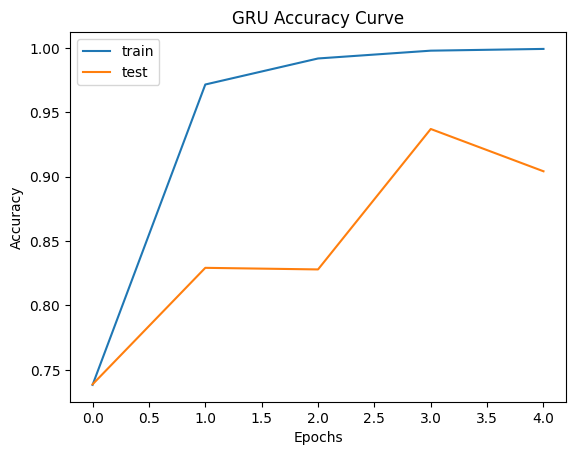

In [22]:
plt.title('GRU Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(range(len(acc)),acc, label='train')
plt.plot(range(len(val_acc)),val_acc, label='test')
plt.legend()
plt.show()

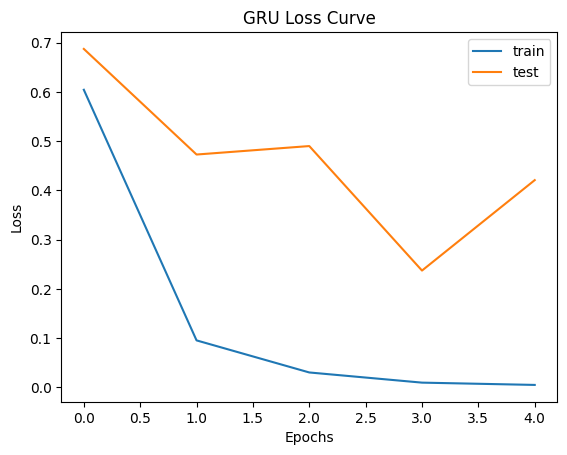

In [23]:
plt.title('GRU Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(len(loss)),loss, label='train')
plt.plot(range(len(val_loss)),val_loss, label='test')
plt.legend()
plt.show()